# Testing the CNN approach

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
#import cv2

import sys
import random

import matplotlib.pyplot as plt
%matplotlib inline

RUN_KAGGLE = False #Set to False if running locally

### &#x2757; Check that you have - tensorflow 2.17.1, keras 3.5.0

#### Move the wildfire dataset to the working directory to be able to make some changes. Currently it is in read-only mode. (Needed only when running on the kaggle server)

In [2]:
if RUN_KAGGLE :
# Source directory
    import shutil

    source_dir = "/kaggle/input/wildfire-prediction-dataset"

    # Destination directory
    destination_dir = "/kaggle/working/wildfire-prediction-dataset"

    shutil.copytree(source_dir, destination_dir)


In [3]:
cur_dir = os.getcwd()
data_path = os.path.relpath('../raw_data', cur_dir)
if RUN_KAGGLE :
    data_path = os.path.relpath('../input', cur_dir)
data_path

'../raw_data'

## 1 Wildfire images

#### Some images are corrupted so we delete them.

In [11]:
files_to_remove = ['train/nowildfire/-114.152378,51.027198.jpg', 'test/wildfire/-73.15884,46.38819.jpg']

if RUN_KAGGLE :
    delete_path = 'wildfire-prediction-dataset'
else :
    delete_path = os.path.join(data_path, 'satellite_images_2_classes')

for file in files_to_remove:
    file_path = os.path.join(delete_path, file)
    if os.path.exists(file_path) :
        #print(file_path)
        os.remove(file_path)
    else :
        print('File does not exist, probably already removed')

#### Function to plot learning curves

In [11]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    # --- LOSS ---

    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    #ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Validation'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)

    # --- ACCURACY

    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='best')
    #ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

### Loading data using tensorflow libraries

In [13]:
from tensorflow.keras.utils import image_dataset_from_directory

def get_train_test_datagens(data_type : str, seed : int, batch_size : int, res : tuple):

    path_to_data = os.path.join('wildfire-prediction-dataset', data_type)

    return image_dataset_from_directory(path_to_data,
                                       seed=seed,
                                       image_size=res,
                                       batch_size=batch_size)

In [14]:
BATCH_SIZE=32

SEED = 42

IMG_RES = (350,350) #image resolution

INPUT_SHAPE = (350,350,3)

In [16]:
train_ds = get_train_test_datagens('train', seed=SEED, batch_size=BATCH_SIZE, res=IMG_RES)
valid_ds = get_train_test_datagens('valid', seed=SEED, batch_size=BATCH_SIZE, res=IMG_RES)
test_ds = get_train_test_datagens('test', seed=SEED, batch_size=BATCH_SIZE, res=IMG_RES)

Found 30249 files belonging to 2 classes.
Found 6300 files belonging to 2 classes.
Found 6299 files belonging to 2 classes.


### Building the model.

In [17]:
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential, layers


def initialize_model_wildfire(l1_reg=0.001, learning_rate=0.001):

    model = Sequential()

    model.add(layers.Input(INPUT_SHAPE))

    #Adding some augmentation layers
    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))
    model.add(layers.RandomZoom(0.5,0.3))

    model.add(layers.Rescaling(1/255, 0.0))
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding ='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l1(l1_reg)))
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l1(l1_reg)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [18]:
model_wildfire = initialize_model_wildfire()
model_wildfire.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 350, 350, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 350, 350, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 350, 350, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 350, 350, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 350, 350, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 175, 175, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 175, 175, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 87, 87, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 59168)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      15,147,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,153,553 (57.81 MB)

 Trainable params: 15,153,553 (57.81 MB)

 Non-trainable params: 0 (0.00 B)

### Highly advised to train on the GPU

In [23]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

history_wildfire = model_wildfire.fit(train_ds,
                            validation_data=valid_ds,
                            batch_size=None,
                            epochs=50,
                            callbacks=[es])

Epoch 1/50


KeyboardInterrupt: 

In [21]:
plot_loss_accuracy(history=history_wildfire)

#### Evaluating on the test set

In [39]:
y_true = np.array([])
y_pred = np.array([])

for x,y in test_ds:
    y_true = np.concatenate([y_true, y])
    y_probs = model_wildfire.predict(x, verbose=0)[:,0]
    y_pred = np.concatenate([y_pred, np.where(y_probs > 0.5, 1, 0)])
    #y_pred = np.concatenate([y_pred, np.argmax(y_probs, axis=1)])

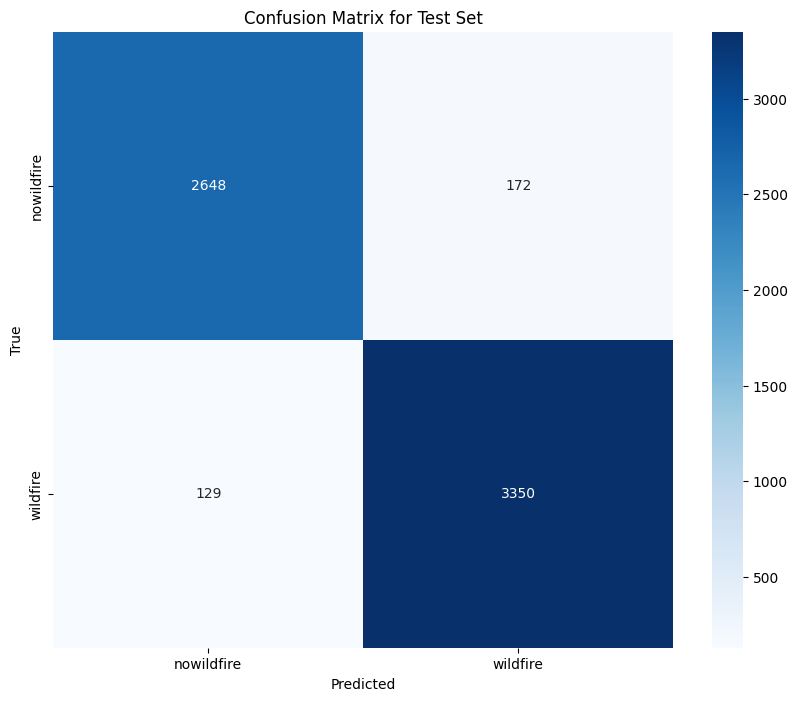

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

In [41]:
print("\nClassification Report for Test Set:")
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))


Classification Report for Test Set:
              precision    recall  f1-score   support

  nowildfire       0.95      0.94      0.95      2820
    wildfire       0.95      0.96      0.96      3479

    accuracy                           0.95      6299
   macro avg       0.95      0.95      0.95      6299
weighted avg       0.95      0.95      0.95      6299



In [42]:
test_accuracy = np.mean(y_true == y_pred)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 95.22%


### Save the model

In [18]:
#model_wildfire.save('/kaggle/working/cnn_2classes_ver2.keras')

### Loading and testing the model

In [33]:
from tensorflow.keras.models import load_model

model_cnn2 = load_model('/kaggle/working/cnn_2classes_ver2.keras')

In [24]:
def load_data_2_classes(reduction_factor=10, resolution = (350,350)):
    """
    Function returns X made up of tensors of shape ((res), 3)
    and labels y {'nowildfire' : 0, 'wildfirew' : 1}
    """
    labels = ['nowildfire', 'wildfire']
    X=[]
    y=[]

    for label in labels:
        path_to_data = os.path.join(data_path,'satellite_images_2_classes', 'test', label)
        if RUN_KAGGLE:
            path_to_data = os.path.join(data_path,'wildfire-prediction-dataset', 'test', label)
        images = np.array(os.listdir(path_to_data))
        idx = np.random.choice(len(images), round(len(images)/reduction_factor), replace=False)
        images_small = images[idx]
        for files in images_small:
            file_path = os.path.join(path_to_data, files)
            img = Image.open(file_path)
            X.append(np.asarray(img.resize(resolution), dtype='uint8')[:,:,:3])
            if label == 'nowildfire':
                y.append(0)
            else :
                y.append(1)

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)

    return np.array(X), np.array(y)

In [38]:
X_test, y_test = load_data_2_classes(reduction_factor=1)

1


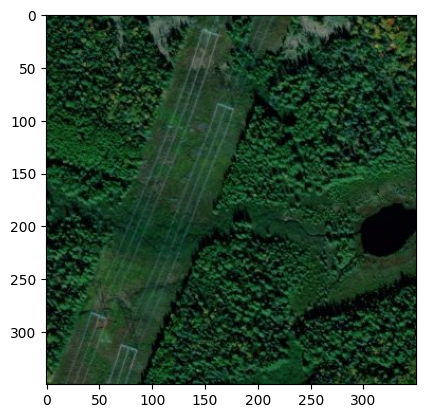

In [48]:
plt.imshow(X_test[300,:,:,:])
print(y_test[300])

In [49]:
model_cnn2.predict(X_test[300:301,:,:,:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


array([[0.9953414]], dtype=float32)

### Trying transfer learning

In [49]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

def model_transfer(learning_rate=0.001, l1_reg=0.001):

    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [51]:
model_inception = model_transfer()
#model_inception.summary()

In [52]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

history_wildfire_transfer = model_inception.fit(train_ds,
                            validation_data=valid_ds,
                            batch_size=None,
                            epochs=50,
                            callbacks=[es])

Epoch 1/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 241s 231ms/step - accuracy: 0.7738 - loss: 1.7671 - val_accuracy: 0.7648 - val_loss: 0.5623
Epoch 2/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 195ms/step - accuracy: 0.8637 - loss: 0.3381 - val_accuracy: 0.8756 - val_loss: 0.3072
Epoch 3/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 196ms/step - accuracy: 0.8792 - loss: 0.2980 - val_accuracy: 0.8821 - val_loss: 0.2938
Epoch 4/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 196ms/step - accuracy: 0.8910 - loss: 0.2739 - val_accuracy: 0.8867 - val_loss: 0.2778
Epoch 5/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 196ms/step - accuracy: 0.8962 - loss: 0.2586 - val_accuracy: 0.8308 - val_loss: 0.3705
Epoch 6/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 196ms/step - accuracy: 0.9023 - loss: 0.2461 - val_accuracy: 0.9163 - val_loss: 0.2203
Epoch 7/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 196ms/step - accuracy: 0.9050 - loss: 0.2366 - val_accuracy: 0.9159 - val_loss: 0.2235
Epoch 8/50
946/946 ━━━━━━━━━━━━━━━━━━━━ 185s 196ms/step - accuracy: 0.9076 -

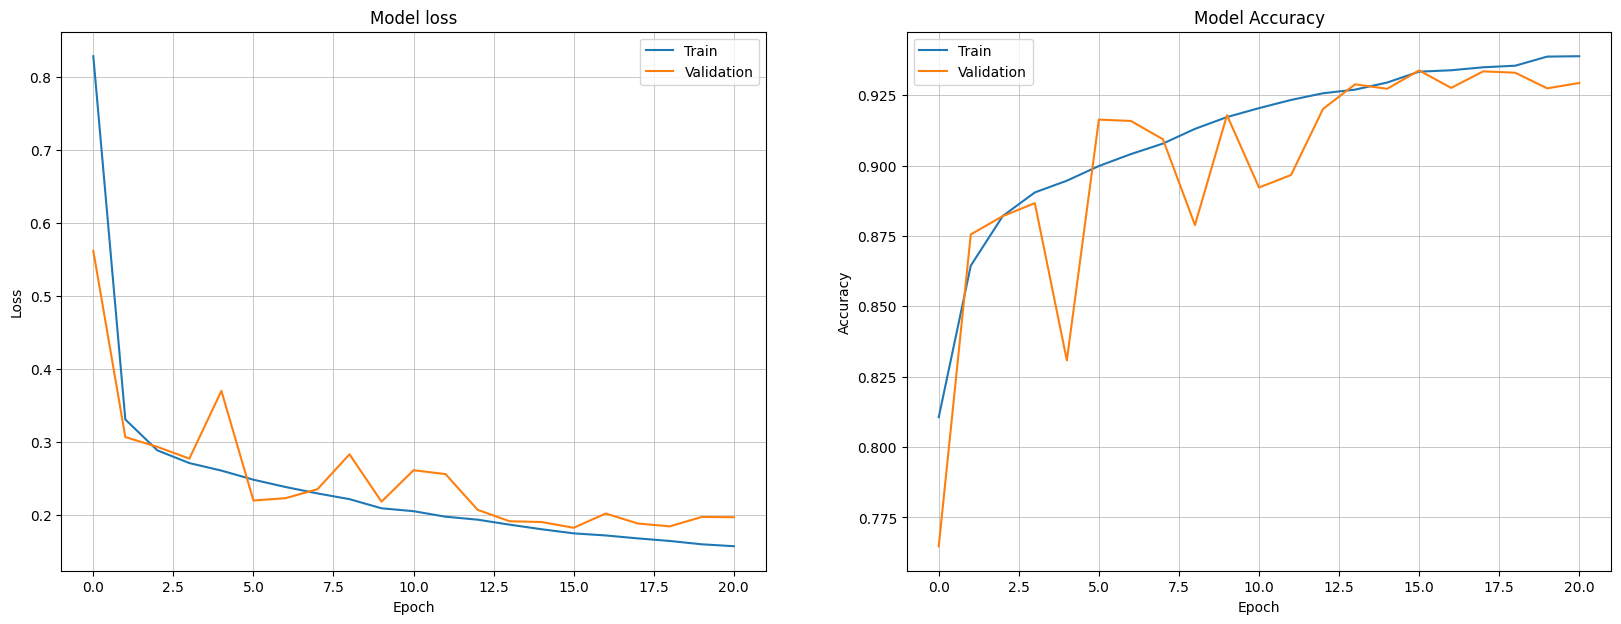

In [53]:
plot_loss_accuracy(history=history_wildfire_transfer)

In [55]:
y_true = np.array([])
y_pred = np.array([])

for x,y in test_ds:
    y_true = np.concatenate([y_true, y])
    y_probs = model_inception.predict(x, verbose=0)[:,0]
    y_pred = np.concatenate([y_pred, np.where(y_probs > 0.5, 1, 0)])
    #y_pred = np.concatenate([y_pred, np.argmax(y_probs, axis=1)])

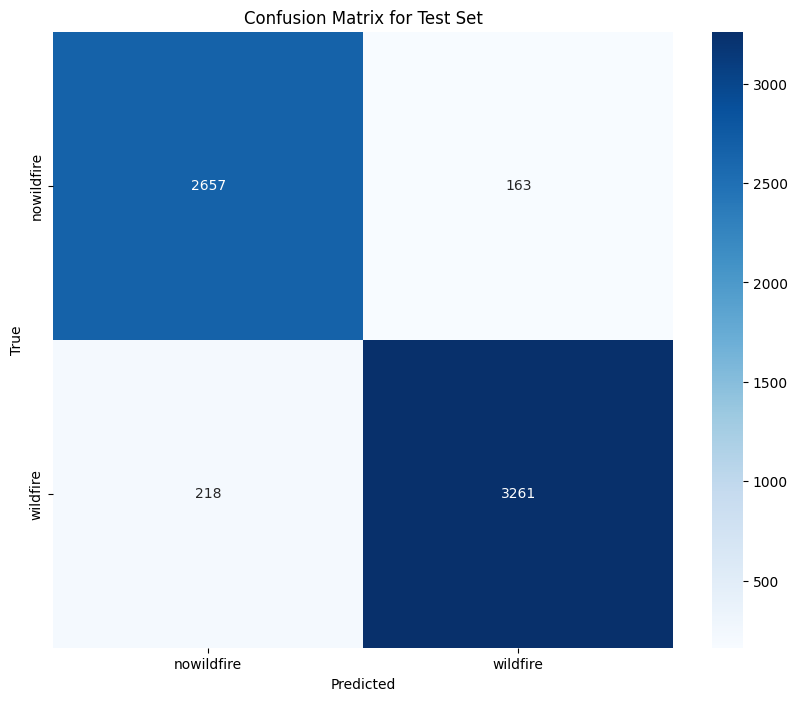

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_ds.class_names, yticklabels=test_ds.class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Test Set')
plt.show()

In [57]:
print("\nClassification Report for Test Set:")
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))


Classification Report for Test Set:
              precision    recall  f1-score   support

  nowildfire       0.92      0.94      0.93      2820
    wildfire       0.95      0.94      0.94      3479

    accuracy                           0.94      6299
   macro avg       0.94      0.94      0.94      6299
weighted avg       0.94      0.94      0.94      6299



In [58]:
#model_inception.save('/kaggle/working/inceptionv3_2classes_ver2.keras')

## 2. Terrain dataset

### Loading the data

In [3]:
def load_data_4_classes(reduction_factor=10, resolution = (256,256)):
    """
    Function returns X made up of tensors of shape ((res), 3)
    and labels y {'cloudy' : 0, 'desert' : 1, 'green_area' : 2, 'water' : 3}
    """
    labels = ['cloudy', 'desert', 'green_area', 'water']
    X=[]
    y=[]

    for label in labels:
        path_to_data = os.path.join(data_path,'satellite-image-classification','data', label)
        images = np.array(os.listdir(path_to_data))
        idx = np.random.choice(len(images), round(len(images)/reduction_factor), replace=False)
        images_small = images[idx]
        for files in images_small:
            file_path = os.path.join(path_to_data, files)
            img = Image.open(file_path)
            X.append(np.asarray(img.resize(resolution), dtype='uint8')[:,:,:3])
            if label == 'cloudy':
                y.append(0)
            elif label == 'desert' :
                y.append(1)
            elif label == 'green_area' :
                y.append(2)
            else :
                y.append(3)

    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)

    return np.array(X), np.array(y)

In [4]:
X, y = load_data_4_classes(reduction_factor=1, resolution = (256,256))

In [5]:
split_frac = 0.2

idx_test =  np.random.choice(X.shape[0], round(X.shape[0]*split_frac), replace=False)
idx_train = [i for i in range(X.shape[0]) if i not in idx_test]

In [6]:
X_train = X[idx_train]
labels_train = y[idx_train]
X_test = X[idx_test]
labels_test = y[idx_test]

In [7]:
from tensorflow.keras.utils import to_categorical

n_labels = len(set(y))

y_train = to_categorical(labels_train, n_labels)
y_test = to_categorical(labels_test, n_labels)

### Building the model

In [19]:
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Sequential, layers


def initialize_model_4classes():

    model = Sequential()

    model.add(layers.Input((256,256,3)))

    model.add(layers.RandomFlip("horizontal"))
    model.add(layers.RandomRotation(0.1))

    model.add(layers.Rescaling(1/255, 0.0))
    model.add(layers.Conv2D(8, (3, 3), activation='relu', padding ='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l1(0.001)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation='relu', kernel_regularizer=l1(0.001)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=l1(0.001)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [20]:
model4 = initialize_model_4classes()
model4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_1 (RandomFlip)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation_1 (RandomRotation)   │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 256, 256, 8)         │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 128, 128, 8)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 16)        │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │       8,388,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           1,028 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,395,924 (32.03 MB)

 Trainable params: 8,395,924 (32.03 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
es = EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

history4 = model4.fit(X_train, y_train, validation_split=0.2, epochs=50, callbacks=[es])

NameError: name 'X_train' is not defined

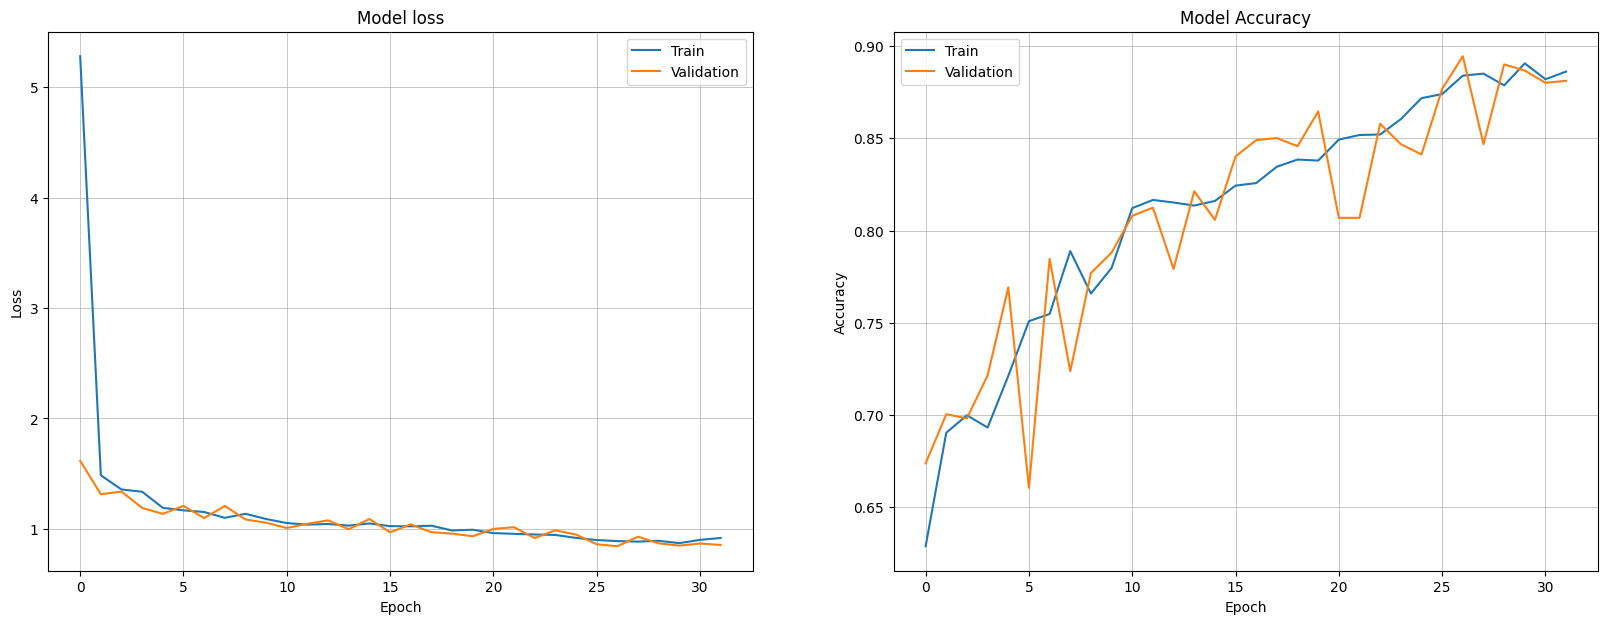

In [15]:
plot_loss_accuracy(history4)

## Structures dataset (14 classes)

In [4]:
def load_data(data_class : str, reduction_factor=10, resize_factor=10):
    X=[]
    y=[]

    path_to_data = os.path.join(data_path, 'satellite_images_14_classes', data_class, 'images')
    path_to_labels = os.path.join(data_path, 'satellite_images_14_classes', data_class, 'labels')
    images = np.array(os.listdir(path_to_data))
    labels = np.array(os.listdir(path_to_labels))
    idx = np.random.choice(len(images), round(len(images)/reduction_factor), replace=False)
    images_small = images[idx]
    labels_small = labels[idx]
    for file, label in zip(images_small, labels_small):
        file_path = os.path.join(path_to_data, file)
        label_path = os.path.join(path_to_labels, label)
        img = Image.open(file_path)
        width, height = img.size
        img_low_res = img.resize((width//resize_factor, height//resize_factor))
        label_vector = np.zeros(10)
        with open(label_path) as f:
            for line in f:
                lab = int(line[0])
                label_vector[lab] = 1
        image = np.asarray(img_low_res, dtype='uint8')
        y.append(label_vector)
        X.append(image)

    return np.array(X), np.array(y)


In [5]:
X_train, labels_train = load_data('train', reduction_factor=1, resize_factor=10)
X_val, labels_val = load_data('valid', reduction_factor=1, resize_factor=10)
X_test, labels_test = load_data('test', reduction_factor=1, resize_factor=10)

In [6]:
X_train_norm = X_train/255
X_val_norm = X_val/255
X_test_norm = X_test/255

In [7]:
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import RMSprop

rmsprop = RMSprop(momentum=0.2)

def initialize_model():

    model = Sequential()

    model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, kernel_size=(5,5), activation='relu', padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, kernel_size=(5,5), activation='relu', padding='same'))
    #model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    #model.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same'))
    #model.add(layers.BatchNormalization())
    #model.add(layers.MaxPool2D(pool_size=(2,2)))
    #model.add(layers.Dropout(0.2))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(10, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

2025-02-05 11:20:38.808998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 11:20:39.049079: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-05 11:20:39.243421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738750839.453756    7111 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738750839.535109    7111 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 11:20:39.972117: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [8]:
model = initialize_model()
model.summary()

/home/bhupend/.pyenv/versions/3.10.6/envs/EnviroClass/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 31, 31, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        50,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,178 (449.91 KB)

 Trainable params: 115,178 (449.91 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
history = model.fit(X_train_norm, labels_train, validation_data=(X_val_norm, labels_val), epochs=20)

Epoch 1/20


2025-02-05 11:21:04.670119: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34406400 exceeds 10% of free system memory.
2025-02-05 11:21:09.767162: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.
2025-02-05 11:21:09.769751: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 23760000 exceeds 10% of free system memory.
2025-02-05 11:21:09.973167: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 29214400 exceeds 10% of free system memory.
2025-02-05 11:21:10.169669: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 19927296 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 261ms/step - accuracy: 0.0691 - loss: 0.5911 - val_accuracy: 0.3050 - val_loss: 0.3839
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.2997 - loss: 0.3794 - val_accuracy: 0.3050 - val_loss: 0.3407
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 187ms/step - accuracy: 0.3011 - loss: 0.3537 - val_accuracy: 0.3050 - val_loss: 0.3367
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.3127 - loss: 0.3389 - val_accuracy: 0.3050 - val_loss: 0.3360
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 184ms/step - accuracy: 0.2804 - loss: 0.3462 - val_accuracy: 0.3050 - val_loss: 0.3357
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 245ms/step - accuracy: 0.2848 - loss: 0.3415 - val_accuracy: 0.3050 - val_loss: 0.3356
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 217ms/step - accuracy: 0.3025 - loss: 0.3314 - val_accuracy: 0.3050 - val_loss: 0.3376
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.3250 - loss: 0.3355 - val_accuracy: 0.3050 - val

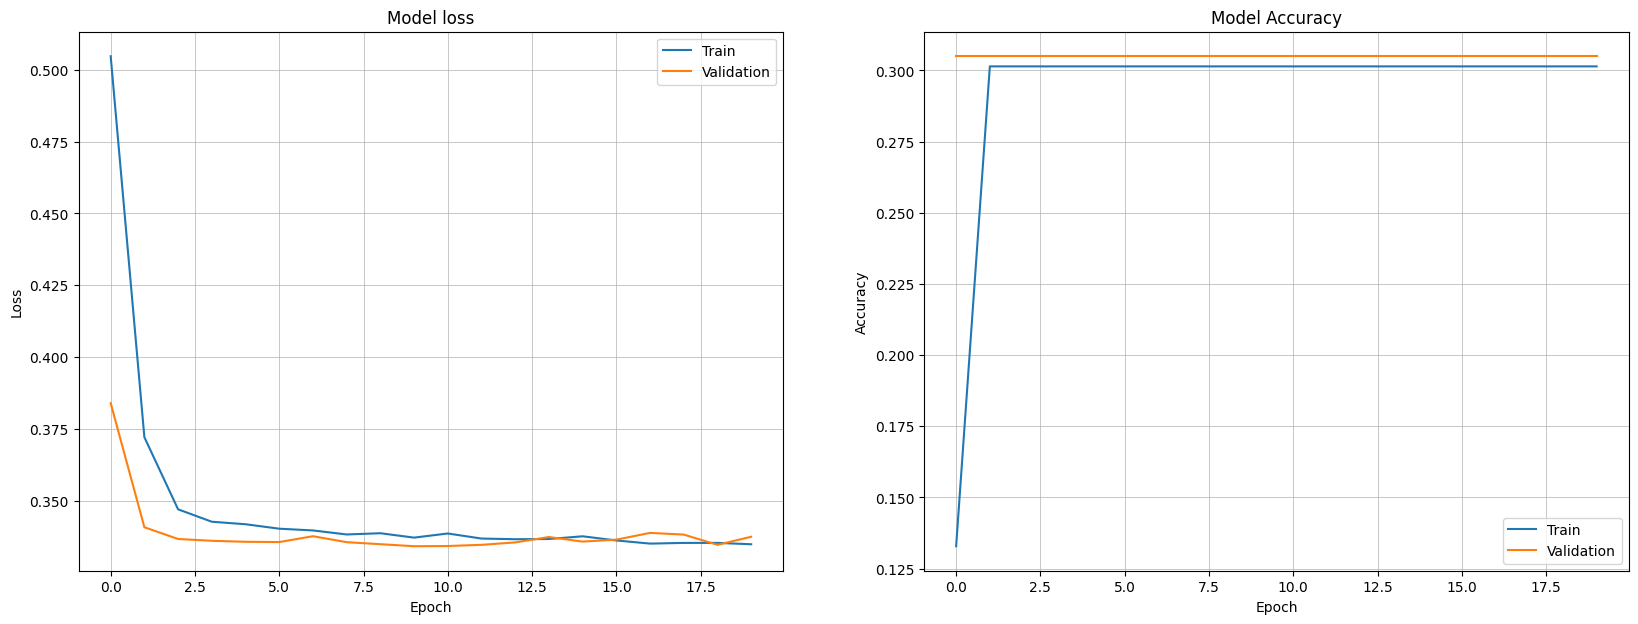

In [12]:
plot_loss_accuracy(history)